# Conversational Chatbot App with Haystack

We are going to create a chabot which enables us to upload documents and query it.The files can be in text(`.txt`), pdf(`.pdf`) and markdown(`.md`) format.

We are going to use `Haystack` as framework and `Cohere` model as LLM. We are going to implement memory so that the chatbot can give us context aware replies.

# Setting Up environment

**Install dependencies**

```
haystack, sentence-transformers, cohere-haystack, python-dotenv
markdown-it-py, mdit_plain, pypdf
gradio
```



In [1]:
%%capture --no-stderr
%%bash
pip install haystack-ai cohere-haystack
pip install sentence-transformers
pip install markdown-it-py mdit_plain pypdf
pip install gradio

Set the API key to the environmental variable

In [4]:
import os, getpass
from google.colab import userdata
import gradio as gr

# if you're using jupyter notebook(enable_secrets)
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_API_KEY')

# if you're using jupyter notebook
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env('COHERE_API_KEY')

# Pre-processing and Indexing Documents

Now, we have to create pre-processing pipeline to index documents. We can create document store using `InMemoryDocumentStore`, you can also replace it with any document store you want.  

In Pre-processing pipeline, the document is routed to the proper converter based on the file type using `FileTypeRouter`. In Haystack, we use converters based on file type.

Each converter will convert the files into Haystack Documents. We can then use `DocumentJoiner` to join all documents.

In [5]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import MarkdownToDocument, PyPDFToDocument, TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=['text/plain','application/pdf','text/markdown'])
pdf_converter = PyPDFToDocument()
text_file_converter = TextFileToDocument()
markdown_converter = MarkdownToDocument()
document_joiner = DocumentJoiner()


The `DocumentCleaner` removes whitespace.`DocumentSplitter` breaks them into chunks of 200 words, with a bit of overlap to avoid missing context.

In [6]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by='word', split_overlap=50)

Now we'll add a `SentenceTransformersDocumentEmbedder` to create embeddings from the documents. As the last step in this pipeline, the `DocumentWriter` will write them to the `InMemoryDocumentStore`

In [7]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L12-v2")
document_writer = DocumentWriter(document_store)

After creating all the components, add them to the indexing pipeline.

In [8]:
# Adding Componenets
preprocessing_pipeline = Pipeline()

preprocessing_pipeline.add_component('file_type_router', file_type_router)
preprocessing_pipeline.add_component('text_file_converter', text_file_converter)
preprocessing_pipeline.add_component('markdown_converter', markdown_converter)
preprocessing_pipeline.add_component('pdf_converter', pdf_converter)
preprocessing_pipeline.add_component('document_joiner', document_joiner)
preprocessing_pipeline.add_component('document_cleaner', document_cleaner)
preprocessing_pipeline.add_component('document_splitter', document_splitter)
preprocessing_pipeline.add_component('document_embedder', document_embedder)
preprocessing_pipeline.add_component('document_writer', document_writer)

Connect the components by indicating which output of a component should be connected to the input of the next component.

In [9]:
# Connecting components

preprocessing_pipeline.connect('file_type_router.text/plain', 'text_file_converter.sources')
preprocessing_pipeline.connect('file_type_router.application/pdf', 'pdf_converter.sources')
preprocessing_pipeline.connect('file_type_router.text/markdown', 'markdown_converter.sources')
preprocessing_pipeline.connect('text_file_converter', 'document_joiner')
preprocessing_pipeline.connect('markdown_converter', 'document_joiner')
preprocessing_pipeline.connect('pdf_converter', 'document_joiner')
preprocessing_pipeline.connect('document_joiner', 'document_cleaner')
preprocessing_pipeline.connect('document_cleaner', 'document_splitter')
preprocessing_pipeline.connect('document_splitter', 'document_embedder')
preprocessing_pipeline.connect('document_embedder', 'document_writer')

🚅 Components
  - file_type_router: FileTypeRouter
  - text_file_converter: TextFileToDocument
  - markdown_converter: MarkdownToDocument
  - pdf_converter: PyPDFToDocument
  - document_joiner: DocumentJoiner
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.text/plain -> text_file_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.application/pdf -> pdf_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.text/markdown -> markdown_converter.sources (List[Union[str, Path, ByteStream]])
  - text_file_converter.documents -> document_joiner.documents (List[Document])
  - markdown_converter.documents -> document_joiner.documents (List[Document])
  - pdf_converter.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> document_cleaner.documents (List[Doc

Use `.show()` to display the pipeline graph

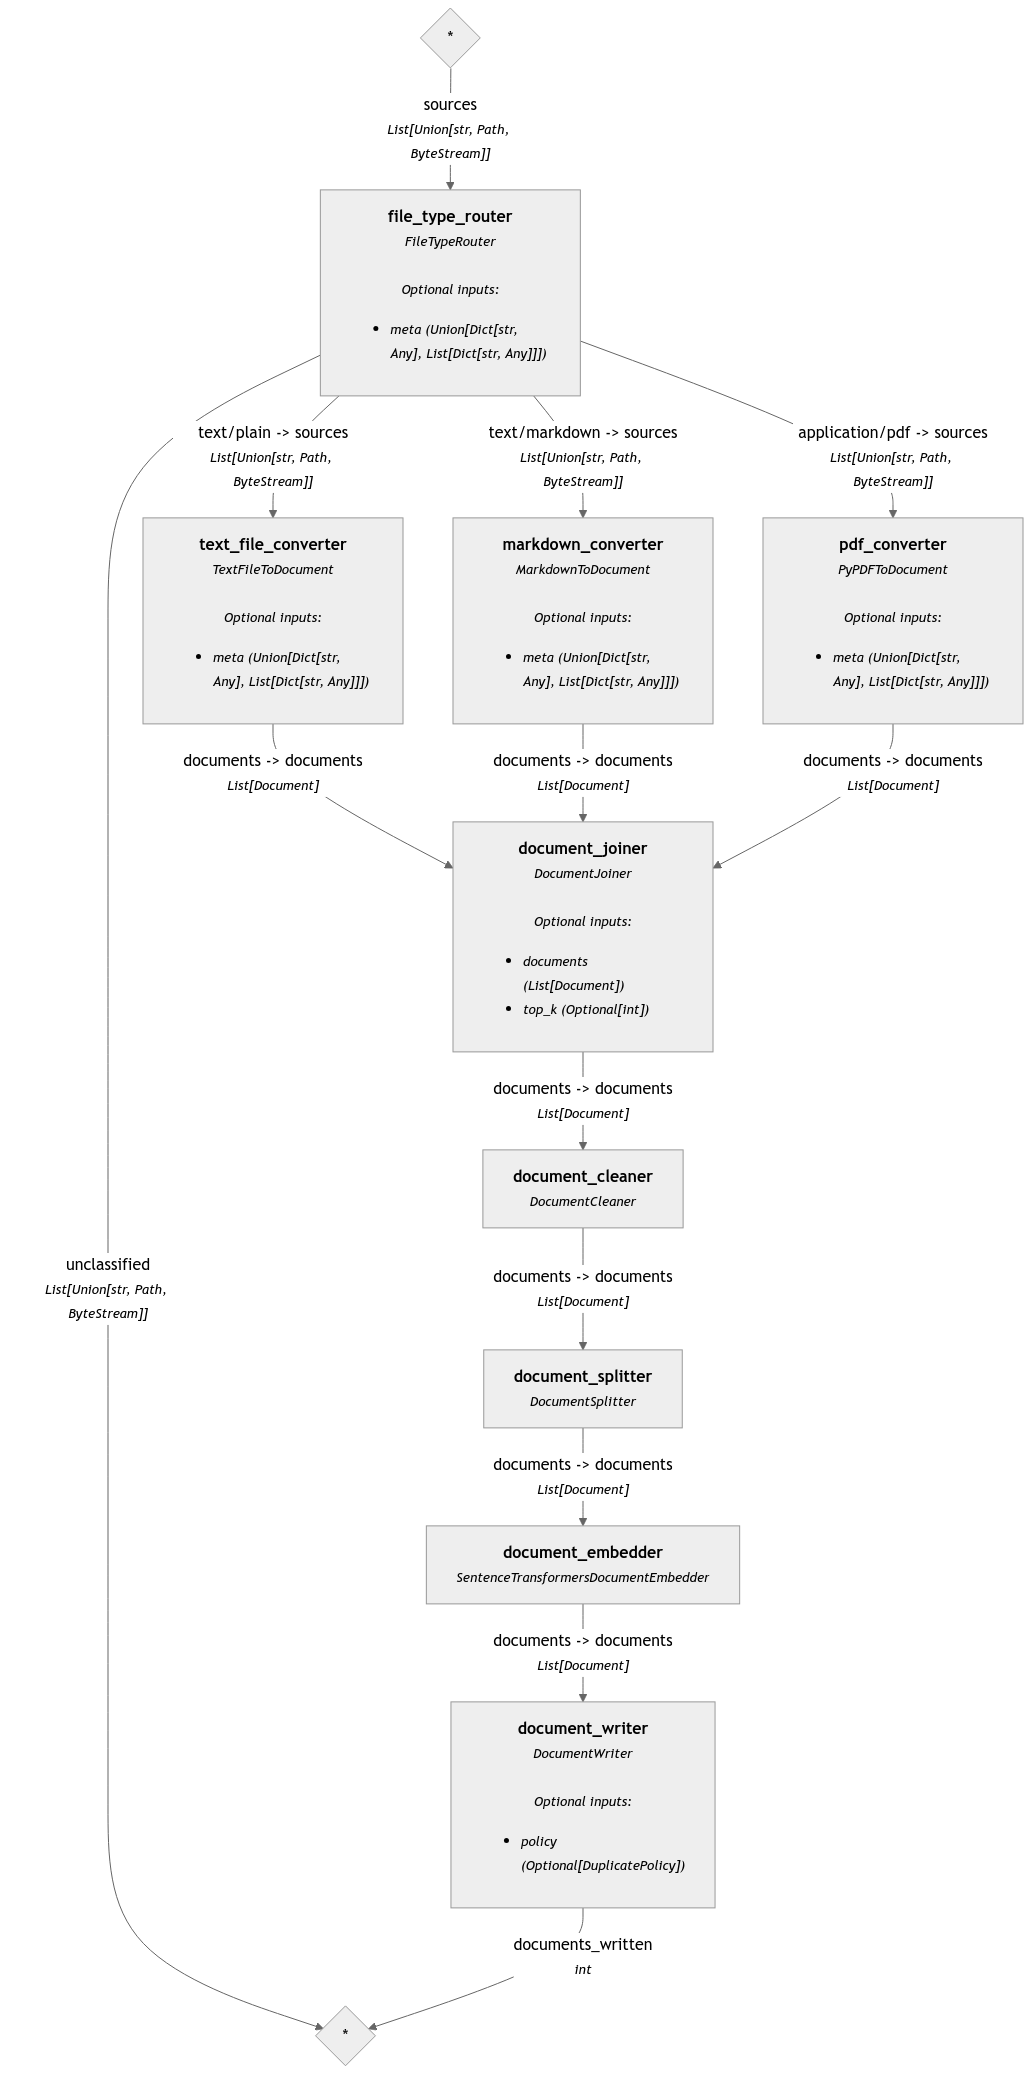

In [10]:
preprocessing_pipeline.show()

# Building the Conversational RAG Pipeline

The conversational RAG pipeline integrates retrieval, **query rephrasing** and response generation with **memory**.

**Query rephrasing** is the process of rewriting a user's query to make it clearer, more specific, or optimized for retrieving the most relevant information, while keeping its original meaning intact. Here we will send the user query to LLM in `query_rephrase_template` prompt and LLM will rephrase the query to include more details.

In [11]:
query_rephrase_template="""
        Rewrite the question for search while keeping its meaning and key terms intact.
        If the conversation history is empty, DO NOT change the query.
        Use conversation history only if necessary, and avoid extending the query with your own knowledge.
        If no changes are needed, output the current question as is.

        Conversation history:
        {% for memory in memories %}
            {{ memory.content }}
        {% endfor %}

        User Query: {{query}}
        Rewritten Query:
"""

Now, we need to need to implement memory, so that our chatbot can retain context from conversations and give us context aware responses.
Create a memory store using `InMemoryChatMessageStore` in which will save our message and retrieve it using `ChatMessageRetriever`.

In [13]:
from haystack_experimental.chat_message_stores.in_memory import InMemoryChatMessageStore

memory_store = InMemoryChatMessageStore()

We will define a component, `ListJoiner` to join the messages from chat.

In [15]:
from haystack import component
from haystack.core.component.types import Variadic
from itertools import chain
from typing import Any, List

@component
class ListJoiner:
  def __init__(self, _type: Any):
    component.set_output_types(self, values=_type)

  def run(self, values:Variadic[Any]):
    result = list(chain(*values))
    return {'values':result}

Create the pipeline query rephrasing, RAG and memory components

In [16]:
from haystack.components.builders import ChatPromptBuilder, PromptBuilder
from haystack.components.converters import OutputAdapter
from haystack_experimental.components.retrievers import ChatMessageRetriever
from haystack_experimental.components.writers import ChatMessageWriter
from haystack_integrations.components.generators.cohere import CohereChatGenerator, CohereGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.dataclasses import ChatMessage

conversational_rag = Pipeline()

#Query rephrasing components
conversational_rag.add_component("query_rephrase_prompt_builder",PromptBuilder(query_rephrase_template))
conversational_rag.add_component('query_rephrase_llm',CohereGenerator())
conversational_rag.add_component('list_to_str_adapter', OutputAdapter(template="{{ replies[0] }}", output_type=str))

#RAG components
conversational_rag.add_component('retriever', InMemoryBM25Retriever(document_store=document_store, top_k=3))
conversational_rag.add_component('prompt_builder', ChatPromptBuilder(variables=["query", "documents", "memories"],required_variables=['query', 'documents', 'memories']))
conversational_rag.add_component('llm', CohereChatGenerator())

#Memory components
conversational_rag.add_component('memory_retriever',ChatMessageRetriever(memory_store))
conversational_rag.add_component('memory_writer', ChatMessageWriter(memory_store))
conversational_rag.add_component('memory_joiner', ListJoiner(List[ChatMessage]))

Now, connect the components

In [17]:
#Query Rephrasing Connections
conversational_rag.connect('memory_retriever', 'query_rephrase_prompt_builder.memories')
conversational_rag.connect('query_rephrase_prompt_builder.prompt', 'query_rephrase_llm' )
conversational_rag.connect('query_rephrase_llm.replies', 'list_to_str_adapter')
conversational_rag.connect('list_to_str_adapter', 'retriever.query')

#RAG connections
conversational_rag.connect('retriever.documents', 'prompt_builder.documents')
conversational_rag.connect('prompt_builder.prompt', 'llm.messages')
conversational_rag.connect('llm.replies', 'memory_joiner')

#Memory Connections
conversational_rag.connect('memory_joiner','memory_writer')
conversational_rag.connect('memory_retriever','prompt_builder.memories')

🚅 Components
  - query_rephrase_prompt_builder: PromptBuilder
  - query_rephrase_llm: CohereGenerator
  - list_to_str_adapter: OutputAdapter
  - retriever: InMemoryBM25Retriever
  - prompt_builder: ChatPromptBuilder
  - llm: CohereChatGenerator
  - memory_retriever: ChatMessageRetriever
  - memory_writer: ChatMessageWriter
  - memory_joiner: ListJoiner
🛤️ Connections
  - query_rephrase_prompt_builder.prompt -> query_rephrase_llm.prompt (str)
  - query_rephrase_llm.replies -> list_to_str_adapter.replies (List[str])
  - list_to_str_adapter.output -> retriever.query (str)
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.messages (List[ChatMessage])
  - llm.replies -> memory_joiner.values (List[ChatMessage])
  - memory_retriever.messages -> query_rephrase_prompt_builder.memories (List[ChatMessage])
  - memory_retriever.messages -> prompt_builder.memories (List[ChatMessage])
  - memory_joiner.values -> memory_writer.messages (List[ChatMes

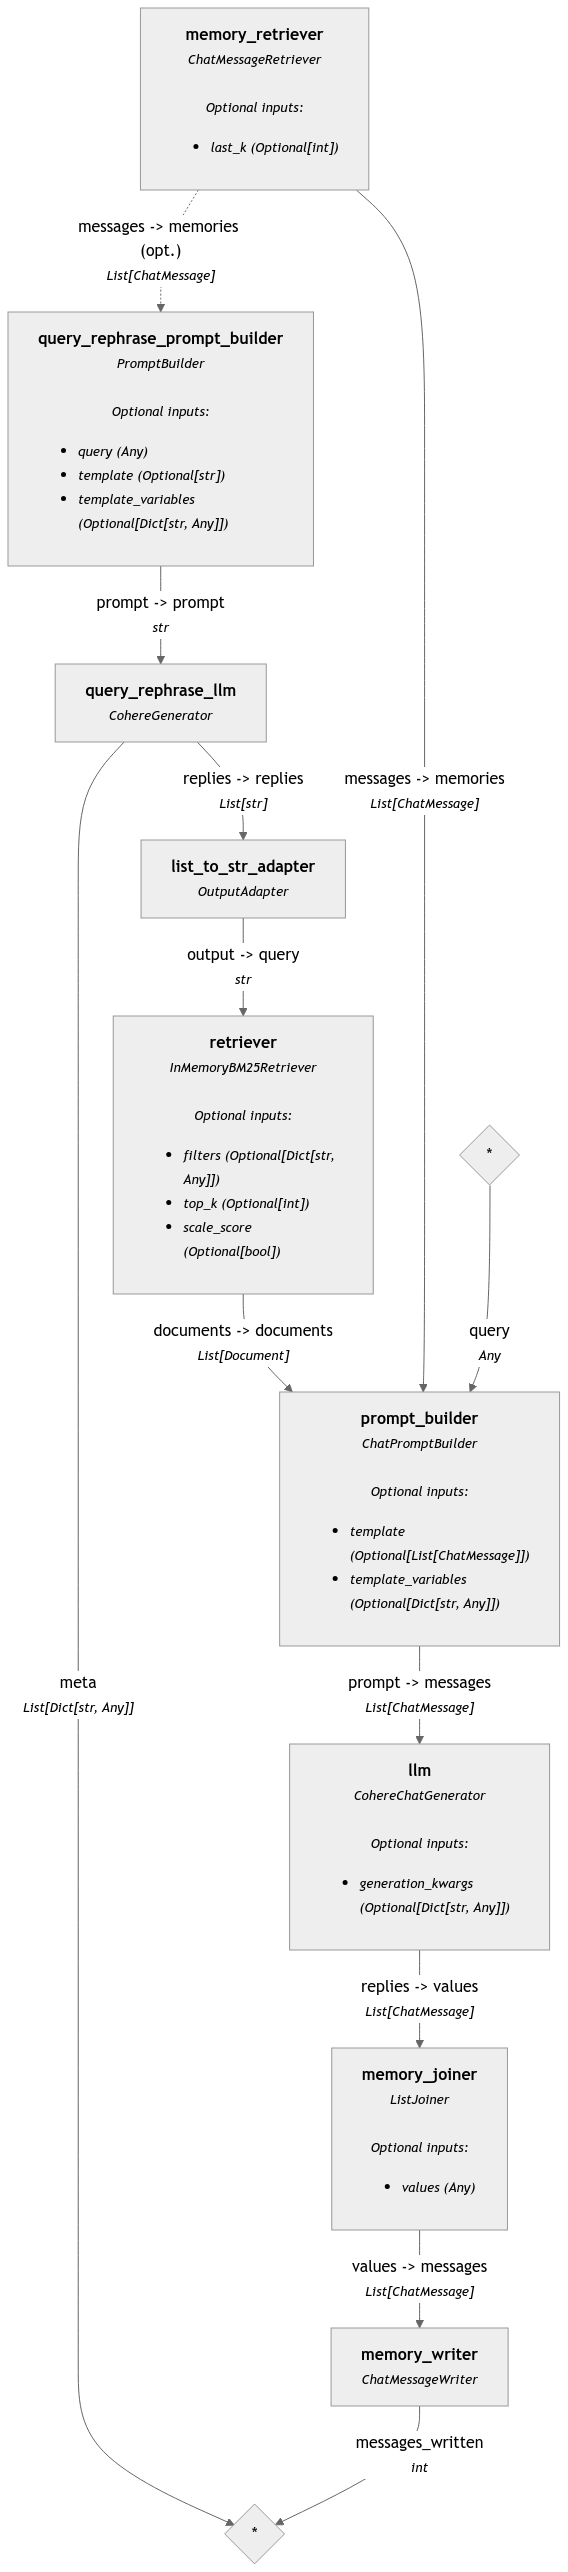

In [18]:
conversational_rag.show()

In [19]:
system_message = ChatMessage.from_system("""You are an intelligent and cheerful AI assistant specialized in assisting humans with queries based on provided supporting documents and conversation history.
                                         Always prioritize accurate and concise answers derived from the documents, and offer contextually relevant follow-up questions to maintain an engaging and helpful conversation.
                                         If the answer is not present in the documents, politely inform the user while suggesting alternative ways to help""")

user_message_template ="""Based on the conversation history and the provided supporting documents, provide a brief and accurate answer to the question.
                          Make the conversation feel more natural and engaging

- Format your response for clarity and readability, using bullet points, paragraphs, or lists where necessary.
- Note: Supporting documents are not part of the conversation history.
- If the question cannot be answered using the supporting documents, respond with: "The answer is not available in the provided documents."

Conversation History:
{% for memory in memories %}
{{ memory.content }}
{% endfor %}

Supporting Documents:
{% for doc in documents %}
{{ doc.content }}
{% endfor %}

Question: {{ query }}
Answer:

"""
user_message = ChatMessage.from_user(user_message_template)

# Creating the User Interface

We will develop a web application using **Gradio** to provide an intuitive interface for document management and interaction. The application will feature a module for uploading documents and initializing a document store with a single click. Additionally, it will include a conversational chat interface, enabling users to query and interact with the content of uploaded PDFs seamlessly.



In [20]:
import time

# Processing Pipeline button function
def process_files_into_docs(pdf_files,progress=gr.Progress()):
  preprocessing_pipeline.run({'file_type_router': {'sources': pdf_files}})
  return "Database created🤗🤗"

# RAG function
def rag(history,question):
  if history is None:
    history=[]
  messages = [system_message, user_message]
  res = conversational_rag.run(
      data = {'query_rephrase_prompt_builder' : {'query': question},
              'prompt_builder': {'template': messages, 'query': question},
              'memory_joiner': {'values': [ChatMessage.from_user(question)]}},
      include_outputs_from=['llm','query_rephrase_llm'])

  bot_message = res['llm']['replies'][0].content

  streamed_message = ""
  for token in bot_message.split():
    streamed_message += f"{token} "
    yield history + [(question, streamed_message.strip())], " "
    time.sleep(0.05)

  history.append((question,bot_message))

  yield history, " "

In [21]:
with gr.Blocks(theme=gr.themes.Soft(font=gr.themes.GoogleFont('Open Sans')))as demo:

  gr.HTML("<center><h1>TalkToFiles - Query your documents! 📂📄</h1><center>")
  gr.Markdown("""##### This AI chatbot🤖 can help you chat with your documents. Can upload <b>Text(.txt), PDF(.pdf) and Markdown(.md)</b> files.\
              <b>Please do not upload confidential documents.</b>""")
  with gr.Row():
    with gr.Column(scale=86):
      gr.Markdown("""#### ***Step 1 - Upload Documents and Initialize RAG pipeline***</br>
                   Can upload Multiple documents""")
      with gr.Row():
        file_input = gr.File(label='Upload Files', file_count='multiple',file_types=['.pdf', '.txt', '.md'],interactive=True)
      with gr.Row():
        process_files = gr.Button('Create Document store')
      with gr.Row():
        result = gr.Textbox(label="Document store", value='Document store not initialized')
        #Pre-processing Events
        process_files.click(fn=process_files_into_docs, inputs=file_input, outputs=result ,show_progress=True)


    with gr.Column(scale=200):
      gr.Markdown("""#### ***Step 2 - Chat with your docs*** """)
      chatbot = gr.Chatbot(label='ChatBot')
      user_input = gr.Textbox(label='Enter your query', placeholder='Type here...')

      with gr.Row():
        submit_button = gr.Button("Submit")
        clear_btn = gr.ClearButton([user_input, chatbot], value='Clear')
        submit_button.click(rag, inputs=[chatbot, user_input], outputs=[chatbot, user_input])

demo.launch()

/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:242: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://221d913632ec9adb07.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


We have created our Conversational RAG chatbot app.🤗🤗